# part 1

In [18]:
import torch
import torchvision
from PIL import Image

In [25]:
a = torch.ones((16, 30, 4))
b = torch.ones((16, 3, 4))

In [26]:
c = a @ b.unsqueeze(1).transpose(-2, -1)
c.shape

torch.Size([16, 16, 30, 3])

# part 2

In [1]:
import torch
import torchvision
from PIL import Image

from src.puzzle import load_dataset
from src.provided_code import get_bunny
from src.rendering import render_point_cloud
import itertools
import matplotlib.pyplot as plt

In [2]:
ds = load_dataset("/Users/vincentlin246/git/6.8300/ps1/data/puzzles")

In [26]:

target_image = ds["images"][0]
src_extrinsics = ds["extrinsics"][0].unsqueeze(0)
src_intrinsics = ds["intrinsics"][0].unsqueeze(0)

src_vertices, _ = get_bunny()

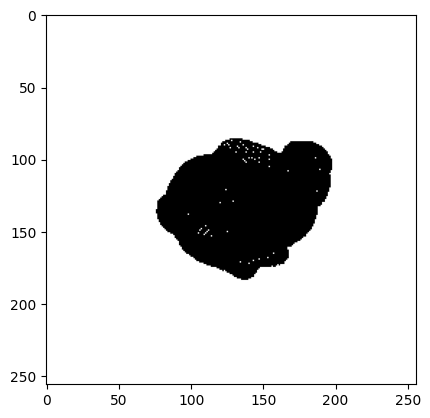

In [4]:
plt.imshow(target_image, cmap="gray")

In [57]:
a = torch.randint(1, 20, (4,4), dtype=torch.float32)
# torch.inverse(a) @ a
a @ torch.inverse(a)

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  1.7881e-07],
        [ 7.4506e-08,  1.0000e+00,  6.7055e-08,  0.0000e+00],
        [ 1.1921e-07,  0.0000e+00,  1.0000e+00,  8.9407e-08],
        [-1.4901e-08, -1.4901e-08,  4.4703e-08,  1.0000e+00]])

In [39]:
T = torch.tensor([
        [ 0., -0., -1.],
        [ 0., -1., -0.],
        [ 1., -0., -0.]
    ])

og = torch.tensor([
    [0, 0, 1],
    [0, -1, 0],
    [1, 0, 0]
], dtype=torch.float32)

og @ T

tensor([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0., -1.]])

In [61]:
a = torch.arange(9.0).reshape(3,3)
print(a)
print(a @ T)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
tensor([[ 2., -1.,  0.],
        [ 5., -4., -3.],
        [ 8., -7., -6.]])


success!
transformation_matrix=tensor([[ 0., -0., -1.],
        [ 0., -1., -0.],
        [ 1., -0., -0.]])


/var/folders/c9/_gyq85b94pj3h64pcn5g23th0000gn/T/ipykernel_98373/827480966.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


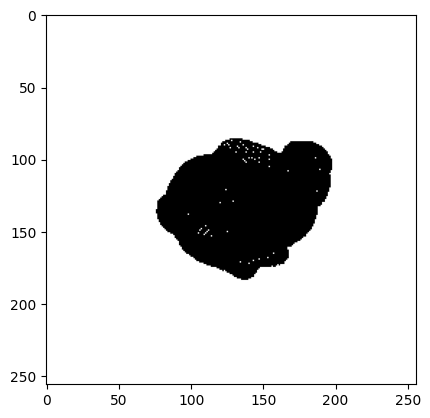

In [29]:
def rotations():
    flag = True

    # try different rotations
    for p_ix, p in enumerate(itertools.permutations(torch.eye(3))):
        for parity_ix, parity in enumerate(list(itertools.product([1, -1], repeat=3))):
            transformation_matrix = torch.stack(p) * torch.tensor(parity)

            R = src_extrinsics[0, :3, :3]
            t = src_extrinsics[0, :3, -1]
            R_prime = R @ transformation_matrix

            transformed_extrinsics = torch.cat((R_prime, t.unsqueeze(1)), dim=1)
            transformed_extrinsics = torch.cat((transformed_extrinsics, torch.tensor([[0,0,0,1]])), dim=0).unsqueeze(0)
            # transformed_extrinsics shape = (batch, 4, 4) where batch = 1 for now

            canvas = render_point_cloud(
                src_vertices,
                transformed_extrinsics,
                src_intrinsics
            )[0]

            if (canvas == target_image).all():
                print('success!')
                print(f"{transformation_matrix=}")
                fig, ax = plt.subplots()
                ax.imshow(canvas, cmap="gray")
                fig.show()
                return

rotations()

In [17]:
src_extrinsics

tensor([[[-0.1573,  0.1778, -0.9714, -0.3145],
         [ 0.7491,  0.6624,  0.0000,  1.4982],
         [-0.6435,  0.7277,  0.2374, -1.2870],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])

In [ ]:
R_opencv = torch.tensor([[1, 0,  0],
                         [0, -1, 0],
                         [0, 0,  1]], dtype=torch.float32)
R = src_extrinsics[0, :3, :3]
Rt = src_extrinsics[0, :3, -1]
R_prime = R_opencv @ torch.inverse(R)

transformed_extrinsics = torch.cat((R_prime, Rt.unsqueeze(1)), dim=1)
transformed_extrinsics = torch.cat((transformed_extrinsics, torch.tensor([[0,0,0,1]])), dim=0).unsqueeze(0)
print(src_extrinsics)
print(transformed_extrinsics)

tensor([[[-0.1573,  0.1778, -0.9714, -0.3145],
         [ 0.7491,  0.6624,  0.0000,  1.4982],
         [-0.6435,  0.7277,  0.2374, -1.2870],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
tensor([[[-1.5725e-01,  7.4912e-01, -6.4349e-01, -3.1451e-01],
         [ 1.7783e-01,  6.6243e-01,  7.2771e-01,  1.4982e+00],
         [-9.7141e-01, -1.3772e-08,  2.3739e-01, -1.2870e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])


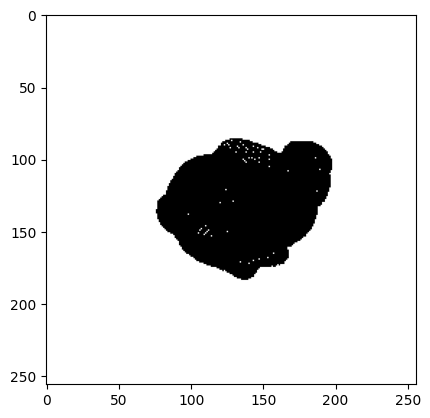

In [31]:
from src.provided_code import generate_spin
from einops import repeat

c2w = generate_spin(16, 15.0, 2.0)[0].unsqueeze(0)
k = torch.eye(3, dtype=torch.float32)
k[:2, 2] = 0.5
k = repeat(k, "i j -> b i j", b=16)[0].unsqueeze(0)

transformation_matrix = torch.tensor([[ 0., -0., -1.],
        [ 0., -1., -0.],
        [ 1., -0., -0.]])
R = src_extrinsics[0, :3, :3]
R_prime = R @ transformation_matrix
transformed_extrinsics = src_extrinsics.clone()
transformed_extrinsics[0, :3, :3] = R_prime

canvas = render_point_cloud(
    src_vertices,
    transformed_extrinsics,
    src_intrinsics
)

plt.imshow(canvas[0], cmap="gray")

# part 3

In [2]:
import numpy as np

In [13]:
a = np.array([[1,1], [2,2]])
b = np.fft.fft2(a)
b

array([[ 6.+0.j,  0.+0.j],
       [-2.+0.j,  0.+0.j]])

In [14]:
np.angle(b)

array([[0.        , 0.        ],
       [3.14159265, 0.        ]])

In [18]:
(np.angle(b) >= -np.pi) * (np.angle(b) <= np.pi) * np.angle(b)

array([[0.        , 0.        ],
       [3.14159265, 0.        ]])

In [16]:
abs(np.fft.ifft2(b))

array([[1., 1.],
       [2., 2.]])

# part 4

In [12]:
import cv2
import numpy as np
from scipy.signal import butter, lfilter

In [10]:
a = np.ones((240, 240, 3))
cv2.pyrDown(a).shape

(120, 120, 3)

In [ ]:
video = np.random.randint(0, 255, (60, 240, 240, 3))
butter(5, (0.4, 3.0), btype="bandpass", fs=30.0)

TypeError: butter() got an unexpected keyword argument 'axis'